In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
import os, sys, json
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from src.utils import load_emorynlp, load_isear, load_tess, filter_emotions, load_emodb, load_ravdess, load_iemocap, load_meld, load_crema_d
from src.processor import FileProcessor
from tqdm import tqdm
tqdm.pandas()

# ===========
# 1) load dataframe
#train_df = load_emorynlp(split='train')
#val_df = load_emorynlp(split='dev')
#test_df = load_emorynlp(split='test')
#isear = filter_emotions(load_isear())
#ISEAR
#df = pd.read_csv("hf://datasets/gsri-18/ISEAR-dataset-complete/ISEAR_dataset_complete.csv")
#df['label'], df['text'] = df['emotion'], df['content']

#emodb = pd.read_csv("EmoDB_transcripts.csv")[['text', 'label']]
#tess = pd.read_csv("TESS_transcripts.csv")[['text', 'label']]
#iemocap = pd.read_csv("IEMOCAP_transcripts.csv")[['text', 'label']]
meld = pd.read_csv("MELD_transcripts.csv")[['text', 'label']]
#iemocap.dropna(inplace=True)
meld.dropna(inplace=True)

df = pd.concat([meld])
#df = filter_emotions(load_crema_d())
#processor = FileProcessor()
#df['text'] = df['filename'].progress_apply(lambda x: processor.process_file(x)['text'])
#df.head()

/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['label'])
#test_df = iemocap

test_df.head()

,text,label
216,It's nothing to freak out about.,neutral
1752,Yes.,neutral
1207,"Yeah, that's fine.",neutral
2107,I also said number one.,neutral
1747,"No, you can't let this stop you from getting ...",sad


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, LeaveOneOut, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec

# -----------------
# Word2Vec Transformer
# -----------------
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=1):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        tokenized = [t.split() for t in X]
        self.model = Word2Vec(sentences=tokenized, vector_size=self.size,
                              window=self.window, min_count=self.min_count, workers=4)
        return self

    def transform(self, X):
        tokenized = [t.split() for t in X]
        features = []
        for tokens in tokenized:
            vecs = [self.model.wv[w] for w in tokens if w in self.model.wv]
            if len(vecs) > 0:
                features.append(np.mean(vecs, axis=0))
            else:
                features.append(np.zeros(self.size))
        return np.array(features)

# -----------------
# Run one experiment (Word2Vec + SVM)
# -----------------
def run_one_example(df):
    X = df['text']
    y = df['label']

    #loo = LeaveOneOut()
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    pipe = Pipeline([
        ('emb', Word2VecTransformer(size=100)),
        ('scaler', StandardScaler()),
        ('clf', SVC())
    ])

    params = {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    }

    grid = GridSearchCV(pipe, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
    grid.fit(X, y)

    return grid.best_score_, grid.best_params_

# -----------------
# Example Usage
# -----------------
best_score, best_params = run_one_example(train_df)
print("Best Score:", best_score)
print("Best Params:", best_params)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   0.9s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.0s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.0s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.0s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.1s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.1s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.1s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.2s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=   0.4s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=   0.4s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=   0.4s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=   0.4s
[CV] END ...................

In [ ]:
from sklearn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec

# -----------------
# Word2Vec Transformer
# -----------------
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=1):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        tokenized = [t.split() for t in X]
        self.model = Word2Vec(sentences=tokenized, vector_size=self.size,
                              window=self.window, min_count=self.min_count, workers=4)
        return self

    def transform(self, X):
        tokenized = [t.split() for t in X]
        features = []
        for tokens in tokenized:
            vecs = [self.model.wv[w] for w in tokens if w in self.model.wv]
            if len(vecs) > 0:
                features.append(np.mean(vecs, axis=0))
            else:
                features.append(np.zeros(self.size))
        return np.array(features)

w2v = Word2VecTransformer().fit(train_df['text'])
X_train = w2v.transform(train_df['text'])
X_val = w2v.transform(val_df['text'])
X_test = w2v.transform(test_df['text'])

In [4]:
X_train

array([[-0.16586305,  0.15887496,  0.08477741, ..., -0.15019833,
         0.03578264, -0.00438157],
       [-0.00170211,  0.01095745,  0.00680555, ..., -0.00612388,
        -0.00324396,  0.00349845],
       [-0.17416805,  0.1637261 ,  0.08605497, ..., -0.15645699,
         0.03835329, -0.00454056],
       ...,
       [-0.15529294,  0.14988501,  0.08264664, ..., -0.14318751,
         0.03552369, -0.00342472],
       [-0.13008595,  0.12508905,  0.06828655, ..., -0.11660501,
         0.02938264, -0.0050382 ],
       [-0.12535386,  0.11852232,  0.06778068, ..., -0.11721023,
         0.02590879, -0.00127909]], dtype=float32)

In [ ]:
results = run_experiment(train_df)
print("Results:")
for k, v in results.items():
    print(k, v)

Fitting 1782 folds for each of 6 candidates, totalling 10692 fits
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.2s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.2s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.3s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.3s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.5s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.6s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.2s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.1s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   1.1s
[CV] END .....................clf__C=0.1, c

## Fine Tune Distil

In [3]:


# ===========
# 2) encode labels (string -> int)
# ===========
le = LabelEncoder()
le.fit(train_df["label"])

train_df["label_id"] = le.transform(train_df["label"])
val_df["label_id"]   = le.transform(val_df["label"])
test_df["label_id"]  = le.transform(test_df["label"])

id2label = {i: l for i, l in enumerate(le.classes_)}
label2id = {l: i for i, l in id2label.items()}

print("Classes:", id2label)


# ===========
# 3) Convert pandas -> Hugging Face Dataset
# ===========
train_ds = Dataset.from_pandas(train_df[["text","label_id"]].rename(columns={"label_id":"labels"}))
val_ds   = Dataset.from_pandas(val_df[["text","label_id"]].rename(columns={"label_id":"labels"}))
test_ds  = Dataset.from_pandas(test_df[["text","label_id"]].rename(columns={"label_id":"labels"}))

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

# ===========
# 4) Tokenizer & model
# ===========
model_name = "distilbert-base-multilingual-cased"
#model_name = "xlm-roberta-base"
#model_name = "distilroberta-base"
#model_name = "meta-llama/Llama-3.2-1B" #"cardiffnlp/twitter-xlm-roberta-base-emotion"
tok = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tok(batch["text"], truncation=True, max_length=64) #128



dataset_tok = dataset.map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tok)

cfg = AutoConfig.from_pretrained(model_name, num_labels=len(le.classes_), id2label=id2label, label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=cfg)

# ===========
# 5) Metrics
# ===========
acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

# ===========
# 6) Trainer
# ===========
args = TrainingArguments(
    output_dir="mdistilbert_emotions",
    #eval_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,#5e-5,
    per_device_train_batch_size=1,#16,
    per_device_eval_batch_size=2,#32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset_tok["train"],
    eval_dataset=dataset_tok["validation"],
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

# ===========
# 7) Train and evaluate
# ===========
trainer.train()
print("Final test results:", trainer.evaluate(dataset_tok["test"]))

# distilbert emodb+tess--iemocap 3ep 21,09

Classes: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


Map: 100%|██████████| 382/382 [00:00<00:00, 45438.99 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the latest cached version of the module from /Users/krazmic/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--accuracy/f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Wed Sep 10 18:03:35 2025) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /Users/krazmic/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--f1/34c46321f42186df33a6260966e34a368f14868d9cc2ba47d142112e2800d233 (last modifie

{'loss': 1.6813, 'learning_rate': 4.953236064347176e-05, 'epoch': 0.03}


  2%|▏         | 100/5346 [01:25<57:09,  1.53it/s] 

{'loss': 1.7039, 'learning_rate': 4.906472128694351e-05, 'epoch': 0.06}


  3%|▎         | 150/5346 [02:02<1:03:25,  1.37it/s]

{'loss': 1.9561, 'learning_rate': 4.859708193041527e-05, 'epoch': 0.08}


  4%|▎         | 200/5346 [02:41<1:20:46,  1.06it/s]

{'loss': 1.5864, 'learning_rate': 4.8129442573887016e-05, 'epoch': 0.11}


  5%|▍         | 250/5346 [03:16<1:10:28,  1.21it/s]

{'loss': 2.0789, 'learning_rate': 4.766180321735878e-05, 'epoch': 0.14}


  6%|▌         | 300/5346 [03:53<1:13:22,  1.15it/s]

{'loss': 2.7312, 'learning_rate': 4.719416386083053e-05, 'epoch': 0.17}


  6%|▌         | 334/5346 [04:18<56:55,  1.47it/s]  

RuntimeError: MPS backend out of memory (MPS allocated: 2.02 GB, other allocations: 16.08 GB, max allowed: 18.13 GB). Tried to allocate 350.24 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

{'loss': 24.9592, 'grad_norm': 1.0552517175674438, 'learning_rate': 0.048660235798499464, 'epoch': 0.08}
{'loss': 1.5166, 'grad_norm': 0.22348372638225555, 'learning_rate': 0.04732047159699893, 'epoch': 0.16}
{'loss': 1.3658, 'grad_norm': 0.3004882335662842, 'learning_rate': 0.045980707395498394, 'epoch': 0.24}
{'loss': 1.3918, 'grad_norm': 0.25394704937934875, 'learning_rate': 0.04464094319399786, 'epoch': 0.32}
{'loss': 1.3852, 'grad_norm': 0.3115262985229492, 'learning_rate': 0.04330117899249732, 'epoch': 0.4}
{'loss': 1.3673, 'grad_norm': 0.3080769181251526, 'learning_rate': 0.04196141479099679, 'epoch': 0.48}
{'loss': 1.3941, 'grad_norm': 0.1880466192960739, 'learning_rate': 0.04062165058949625, 'epoch': 0.56}

In [4]:
from sklearn.metrics import classification_report

preds = trainer.predict(dataset_tok["test"])
print(classification_report(preds.label_ids, np.argmax(preds.predictions, axis=1), target_names=le.classes_))


100%|██████████| 191/191 [00:02<00:00, 76.70it/s]

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        50
     disgust       0.00      0.00      0.00        10
        fear       0.00      0.00      0.00         8
       happy       0.00      0.00      0.00        59
     neutral       0.48      1.00      0.65       183
         sad       0.00      0.00      0.00        31
    surprise       0.00      0.00      0.00        41

    accuracy                           0.48       382
   macro avg       0.07      0.14      0.09       382
weighted avg       0.23      0.48      0.31       382



## Experiment 4

In [4]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import os, sys
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from src.recognizers import TextEmotionRecognizer
from src.evaluation import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
df = test_df

100%|██████████| 382/382 [02:02<00:00,  3.11it/s]

              precision    recall  f1-score   support

       angry       0.31      0.24      0.27        50
     disgust       0.05      0.10      0.07        10
        fear       0.07      0.12      0.09         8
       happy       0.30      0.12      0.17        59
     neutral       0.80      0.17      0.29       183
         sad       0.28      0.16      0.20        31
    surprise       0.13      0.73      0.22        41

    accuracy                           0.23       382
   macro avg       0.28      0.24      0.19       382
weighted avg       0.51      0.23      0.24       382



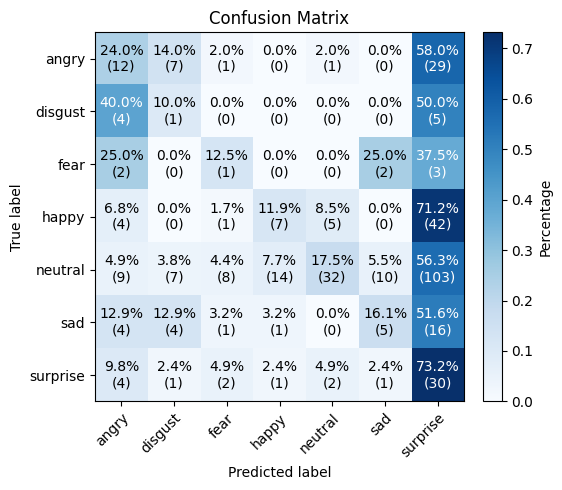

In [4]:
ter = TextEmotionRecognizer("gemma3:4b")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

100%|██████████| 382/382 [03:25<00:00,  1.85it/s]

              precision    recall  f1-score   support

       angry       0.40      0.24      0.30        50
     disgust       0.11      0.20      0.14        10
        fear       0.08      0.12      0.10         8
       happy       0.40      0.10      0.16        59
     neutral       0.58      0.65      0.61       183
         sad       0.67      0.19      0.30        31
    surprise       0.21      0.46      0.29        41

    accuracy                           0.43       382
   macro avg       0.35      0.28      0.27       382
weighted avg       0.47      0.43      0.42       382



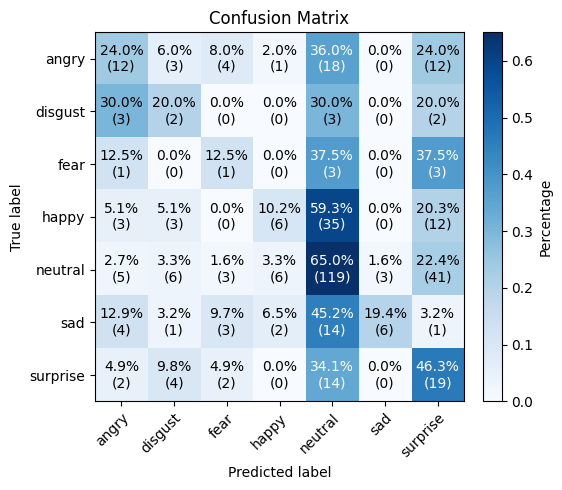

In [5]:
ter = TextEmotionRecognizer("gemma2")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

  0%|          | 0/382 [00:00<?, ?it/s]

100%|██████████| 382/382 [02:44<00:00,  2.32it/s]


              precision    recall  f1-score   support

       angry       0.33      0.42      0.37        50
     disgust       1.00      0.10      0.18        10
        fear       0.20      0.12      0.15         8
       happy       0.29      0.07      0.11        59
     neutral       0.55      0.42      0.47       183
         sad       0.15      0.26      0.19        31
    surprise       0.14      0.37      0.20        41

    accuracy                           0.33       382
   macro avg       0.38      0.25      0.24       382
weighted avg       0.41      0.33      0.34       382



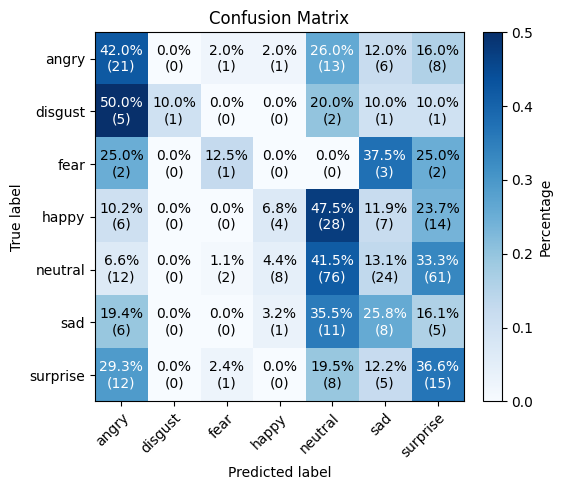

In [5]:
ter = TextEmotionRecognizer("gemma")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

100%|██████████| 382/382 [01:32<00:00,  4.12it/s]

              precision    recall  f1-score   support

       angry       0.56      0.10      0.17        50
     disgust       1.00      0.10      0.18        10
        fear       0.00      0.00      0.00         8
       happy       0.14      0.05      0.07        59
     neutral       0.51      0.93      0.66       183
         sad       0.42      0.16      0.23        31
    surprise       0.00      0.00      0.00        41

    accuracy                           0.48       382
   macro avg       0.37      0.19      0.19       382
weighted avg       0.40      0.48      0.37       382



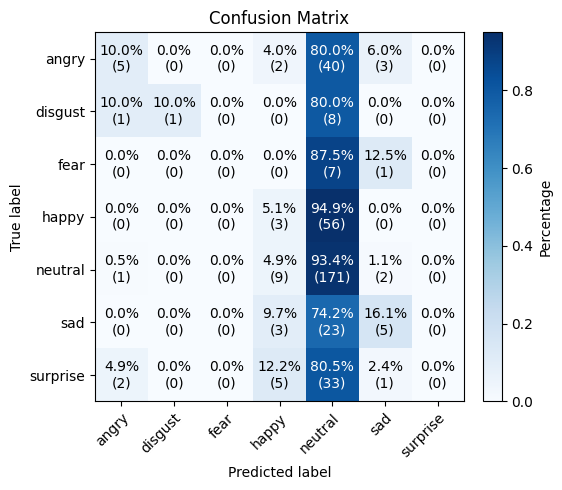

In [6]:
ter = TextEmotionRecognizer("qwen")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

100%|██████████| 382/382 [02:50<00:00,  2.25it/s]

              precision    recall  f1-score   support

       angry       0.42      0.32      0.36        50
     disgust       0.12      0.10      0.11        10
        fear       0.00      0.00      0.00         8
       happy       0.27      0.37      0.31        59
     neutral       0.62      0.55      0.58       183
         sad       0.33      0.32      0.33        31
    surprise       0.32      0.41      0.36        41

    accuracy                           0.43       382
   macro avg       0.30      0.30      0.29       382
weighted avg       0.46      0.43      0.44       382



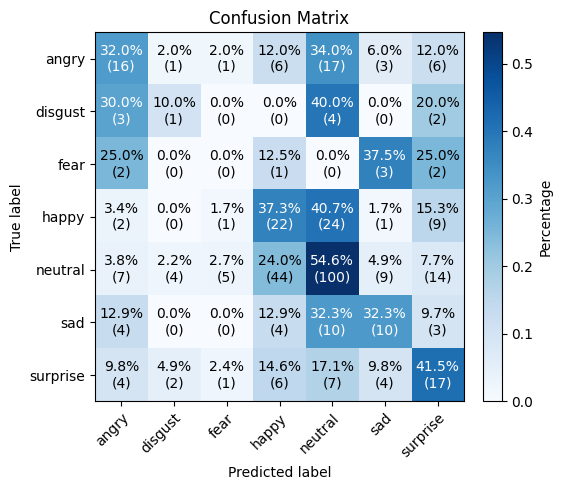

In [7]:
ter = TextEmotionRecognizer("glm4")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

In [5]:
ter = TextEmotionRecognizer("mistral")
df['pred'] = df['text'].progress_apply(ter.analyze)

print(classification_report(df['label'], df['pred']))
plot_confusion_matrix(df['label'], df['pred'])

 76%|███████▌  | 289/382 [12:18<03:57,  2.55s/it]


KeyboardInterrupt: 